In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,default_data_collator
import torch
from peft import PeftModel
from transformers import GenerationConfig
from transformers.generation.utils import LogitsProcessorList
from transformers.generation.logits_process import LogitsProcessor
from datasets import load_dataset
from torch.utils.data import DataLoader
import os

abs_path = "/data/home/chenpz/git_clone_project"
model_path = f"{abs_path}/All_base_model/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/d3aa29f914761e8ea0298051fbaf8dd173e94db5"
data_path = f"/data/home/chenpz/git_clone_project/nlpData/p3/anli_r3_json_file/anli_r3_train_FFP_all.json"
# adpter_path = f"/data/home/chenpz/git_clone_project/LLaMA-Factory/saves/llama3-8b-anli_r3_train_kcg_addHighPPL_first5000_data_gas=5_lr=1e-4/checkpoint-60"
output_file = '/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/anli_r3_PPL_FFP_all.jsonl'

output_dir = os.path.dirname(output_file)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


device = 'cuda:1'
prompt = \
'''<|begin_of_text|><|start_header_id|>user<|end_header_id|>

{instruction} {input}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{output}<|eot_id|>'''



# nf4_config = BitsAndBytesConfig(
#    load_in_4bit=True,
#    bnb_4bit_quant_type="nf4",
#    bnb_4bit_use_double_quant=True,
#    bnb_4bit_compute_dtype= None
# )


model = AutoModelForCausalLM.from_pretrained(model_path, 
                                             torch_dtype=torch.bfloat16,
                                            #  quantization_config=nf4_config,
                                             device_map = device)

# model = PeftModel.from_pretrained(
#                     model, adpter_path, is_trainable=False
#                     )




/data/home/chenpz/.conda/envs/sft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_path,use_fast=False,split_special_tokens=False,
                                          padding_side="left",
                                          **{'trust_remote_code': True, 'cache_dir': None, 'revision': 'main', 'use_auth_token': None})
tokenizer.pad_token = '<|eot_id|>'

dataset = load_dataset("json", data_files= data_path)

# def preprocess_supervised_data(examples):
#     model_inputs = {'input_ids': [],
#                     'attention_mask':[],
#                     # 'prompt':[]
#                     }
#     for  instruction,input,output in zip(examples['instruction'],examples['input'],examples['output']):
#            text = prompt.format(instruction = instruction, input = input, output = output)
#            res = tokenizer(text,padding='max_length',max_length=1300,truncation=True)
#            model_inputs['input_ids'].append(res['input_ids'])
#            model_inputs['attention_mask'].append(res['attention_mask'])
#           #  model_inputs['prompt'].append(text)
#     return model_inputs


IGNORE_INDEX = -100

question_prompt = '''<|begin_of_text|><|start_header_id|>user<|end_header_id|>

{instruction}{input}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''

answer_prompt = '''{output}<|eot_id|>'''

def preprocess_supervised_data(examples) :
        model_inputs = {"input_ids": [], "attention_mask": [], "labels": []}
        max_length = 400
        for  instruction,input,output in zip(examples['instruction'],examples['input'],examples['output']):

            query = question_prompt.format(instruction = instruction, input = input)
            response= answer_prompt.format(output = output)
            
            input_ids, labels = [], []
            source_ids, target_ids = tokenizer([query,response])['input_ids']
            input_ids += source_ids + target_ids
            if len(input_ids) > max_length:
                 print('warning')
            input_ids = input_ids[:max_length]

            labels += [IGNORE_INDEX] * len(source_ids) + target_ids
            labels = labels[:max_length]
            
            model_inputs["input_ids"].append(input_ids)
            model_inputs["attention_mask"].append([1] * len(input_ids))
            model_inputs["labels"].append(labels)

        # Padding: Ensure that all input sequences have the same length
        for i in range(len(model_inputs["input_ids"])):
            padding_length = max_length - len(model_inputs["input_ids"][i])
            
            # Left padding input_ids and attention_mask
            model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * padding_length + model_inputs["input_ids"][i]
            model_inputs["attention_mask"][i] = [0] * padding_length + model_inputs["attention_mask"][i]

            # Left padding labels with IGNORE_INDEX
            model_inputs["labels"][i] = [IGNORE_INDEX] * padding_length + model_inputs["labels"][i]
        
        return model_inputs



dataset2 = dataset.map(preprocess_supervised_data,batched=True,remove_columns=['output', 'input', 'instruction'],num_proc=16)

print(tokenizer.decode(dataset2['train'][0]['input_ids']))

eval_dataloader = DataLoader(dataset2['train'],batch_size=4, pin_memory=True,collate_fn=default_data_collator,shuffle=False)


<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>

In [12]:
from tqdm import tqdm
model.eval()
loss_list =[]
loss_fn = torch.nn.CrossEntropyLoss(
    reduction='none'
    ) # 不要平均，保留每个 token 的 loss
with open(output_file, 'w') as file:  # Open the file in write mode before the loop
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            # outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits
            shift_logits = logits[..., :-1, :].contiguous()  # 移动 logits 以对齐预测
            shift_labels = batch['labels'][:, 1:].contiguous()  # 移动 labels
            
            # 计算每个 token 的 loss
            loss_per_token = loss_fn(shift_logits.view(-1, model.config.vocab_size), shift_labels.view(-1))
            # reshape 回到 batch 大小
            loss_per_token = loss_per_token.view(shift_labels.size())
            
            # means = []
            # for row in loss_per_token:
            #     non_zero_elements = row[row != 0]  # 提取非零元素
            #     if non_zero_elements.numel() > 0:  # 确保非零元素存在
            #         mean_non_zero = non_zero_elements.mean()
            #         means.append(mean_non_zero.item())  # 将均值添加到列表中
            #     else:
            #         means.append(0)  # 如果该行全为零，均值为0

            # fast compute version
            means = loss_per_token.sum(dim=-1) / (loss_per_token != 0).sum(dim=-1)
            means = list( means.cpu().numpy() )

            # print(loss_per_sample)
            for i, loss in enumerate(means):
                # print(loss)
                # break
                sample_id = step * eval_dataloader.batch_size + i  # 用于区分每个样本的索引
                add_item = {'id':sample_id,'loss':loss}
                file.write('%s\n' % add_item)

100%|██████████| 25115/25115 [1:21:24<00:00,  5.14it/s]


# mixed alpaca data

## origion data

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/test_loss_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

z = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/mixed_alpaca_answerPPL_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        # x.append(data['id'])
        z.append(data['loss'])

ifd = np.exp(y)/np.exp(z)

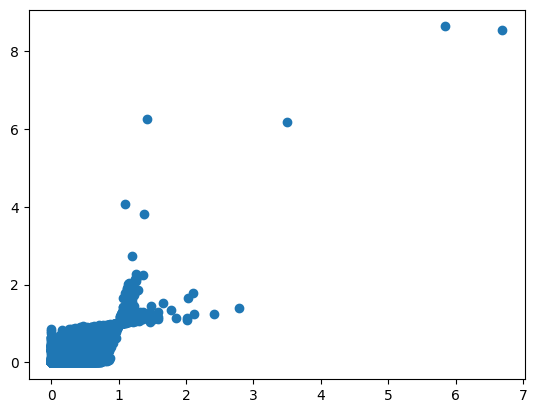

In [7]:
plt.scatter(y/np.array(z), ifd )

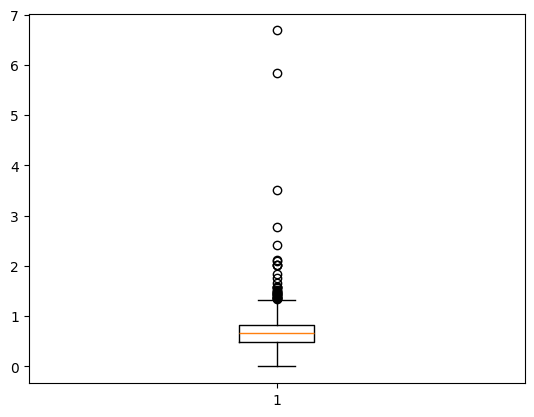

In [14]:
r = plt.boxplot(y/np.array(z))

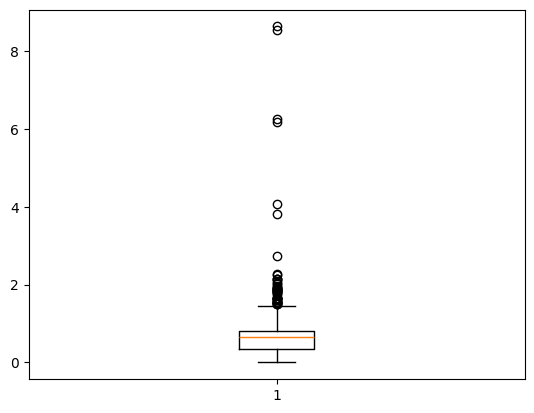

In [13]:
r = plt.boxplot(ifd)

In [15]:
import pickle

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/alpacaAndEvol.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    res1 = pickle.load(f)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/aplaca_mix_fps_rank.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    res2 = pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
# y = [y[index_dict[value]] for value in res2[0]]

In [33]:
# print(len())
# print(len())

res1_loss = y
res2_loss = [y[index_dict[value]] for value in res2[0]]
set1 = list(set(res1[0][:5000]).intersection(set(res2[0][:5000])))
set2 = list(set(res1[0][-5000:]).intersection(set(res2[0][-5000:])))

set1_loss = np.array([y[index_dict[value]] for value in set1])
set2_loss = np.array([y[index_dict[value]] for value in set2])
np.mean(res1_loss[-5000:-1000]), np.mean(res2_loss[-5000:]) , np.mean(set1_loss) , np.mean(set2_loss) 

(1.4858890229117097,
 1.1138221530491486,
 1.2576528763871022,
 2.3007890869548002)

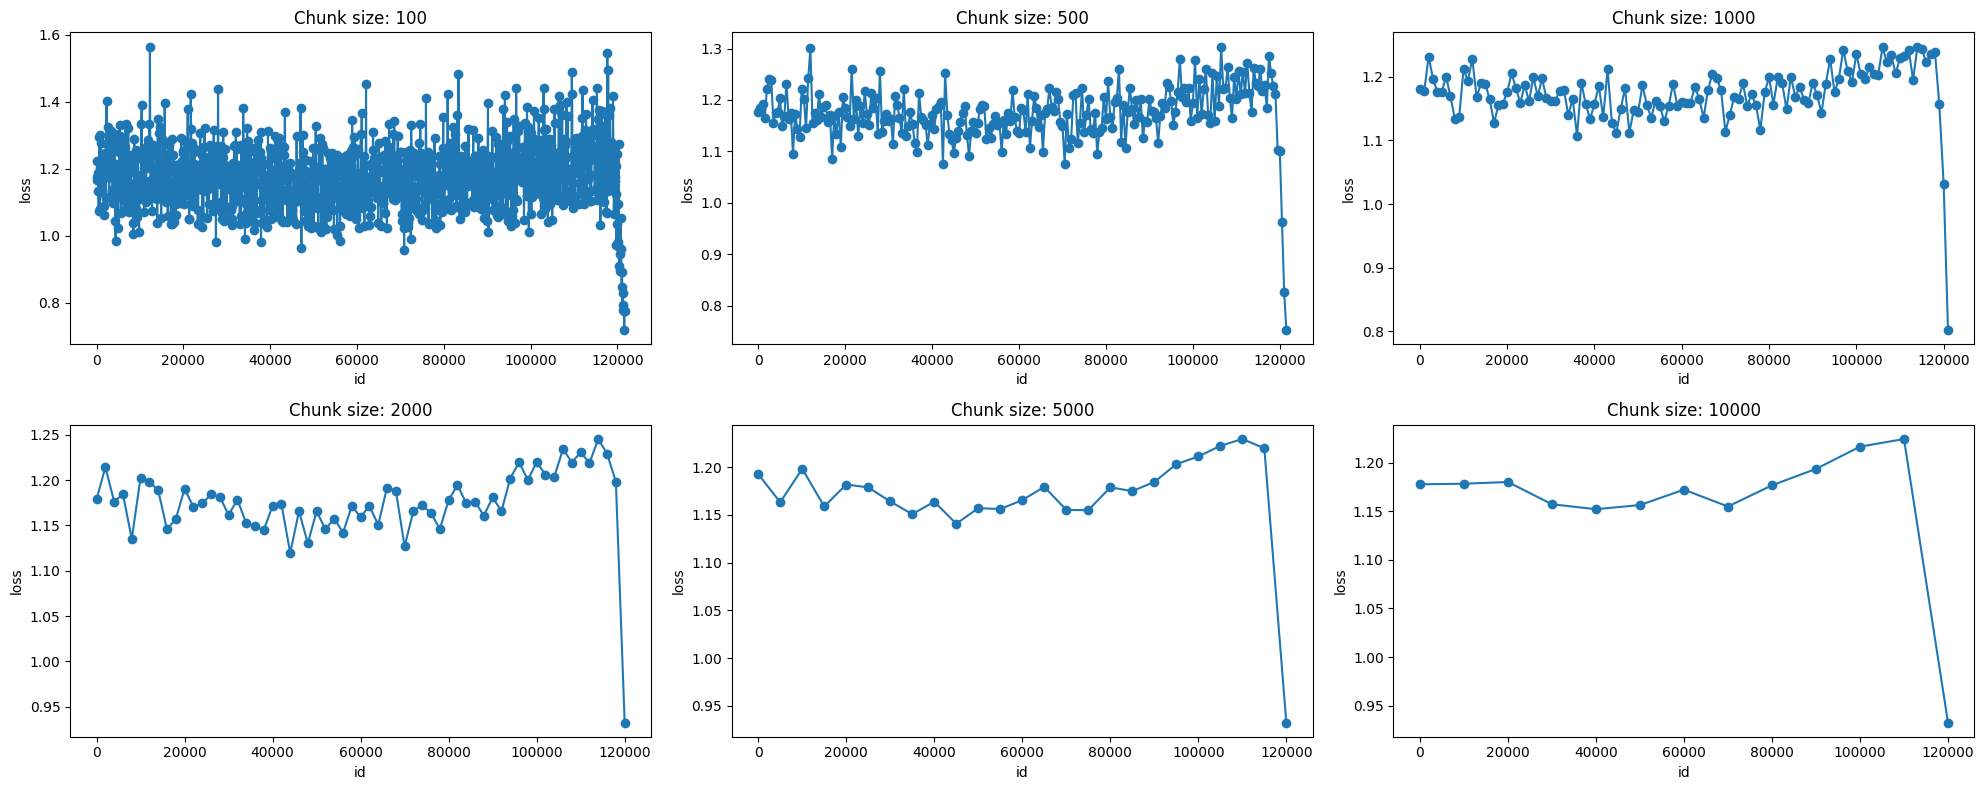

In [3]:
# 定义不同的chunk大小
chunk_sizes = [100, 500, 1000, 2000, 5000, 10000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [2]:
# 均分数据的大小
print(f"dataset: mixed alpaca data, 数据量为：{len(y)}")
chunk_sizes = [1, 10,50, 100, 500, 1000, 2000, 5000, 10000]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.5
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: mixed alpaca data, 数据量为：121760
chunk_sizes大小为: 1, 选取后50.0%的数据, spearman_corr: 0.161696418554925
chunk_sizes大小为: 10, 选取后50.0%的数据, spearman_corr: 0.331485091875736
chunk_sizes大小为: 50, 选取后50.0%的数据, spearman_corr: 0.555255915265396
chunk_sizes大小为: 100, 选取后50.0%的数据, spearman_corr: 0.6580326593759694
chunk_sizes大小为: 500, 选取后50.0%的数据, spearman_corr: 0.8356029489030835
chunk_sizes大小为: 1000, 选取后50.0%的数据, spearman_corr: 0.906081438392385
chunk_sizes大小为: 2000, 选取后50.0%的数据, spearman_corr: 0.9491935483870969
chunk_sizes大小为: 5000, 选取后50.0%的数据, spearman_corr: 0.9835164835164836
chunk_sizes大小为: 10000, 选取后50.0%的数据, spearman_corr: 1.0


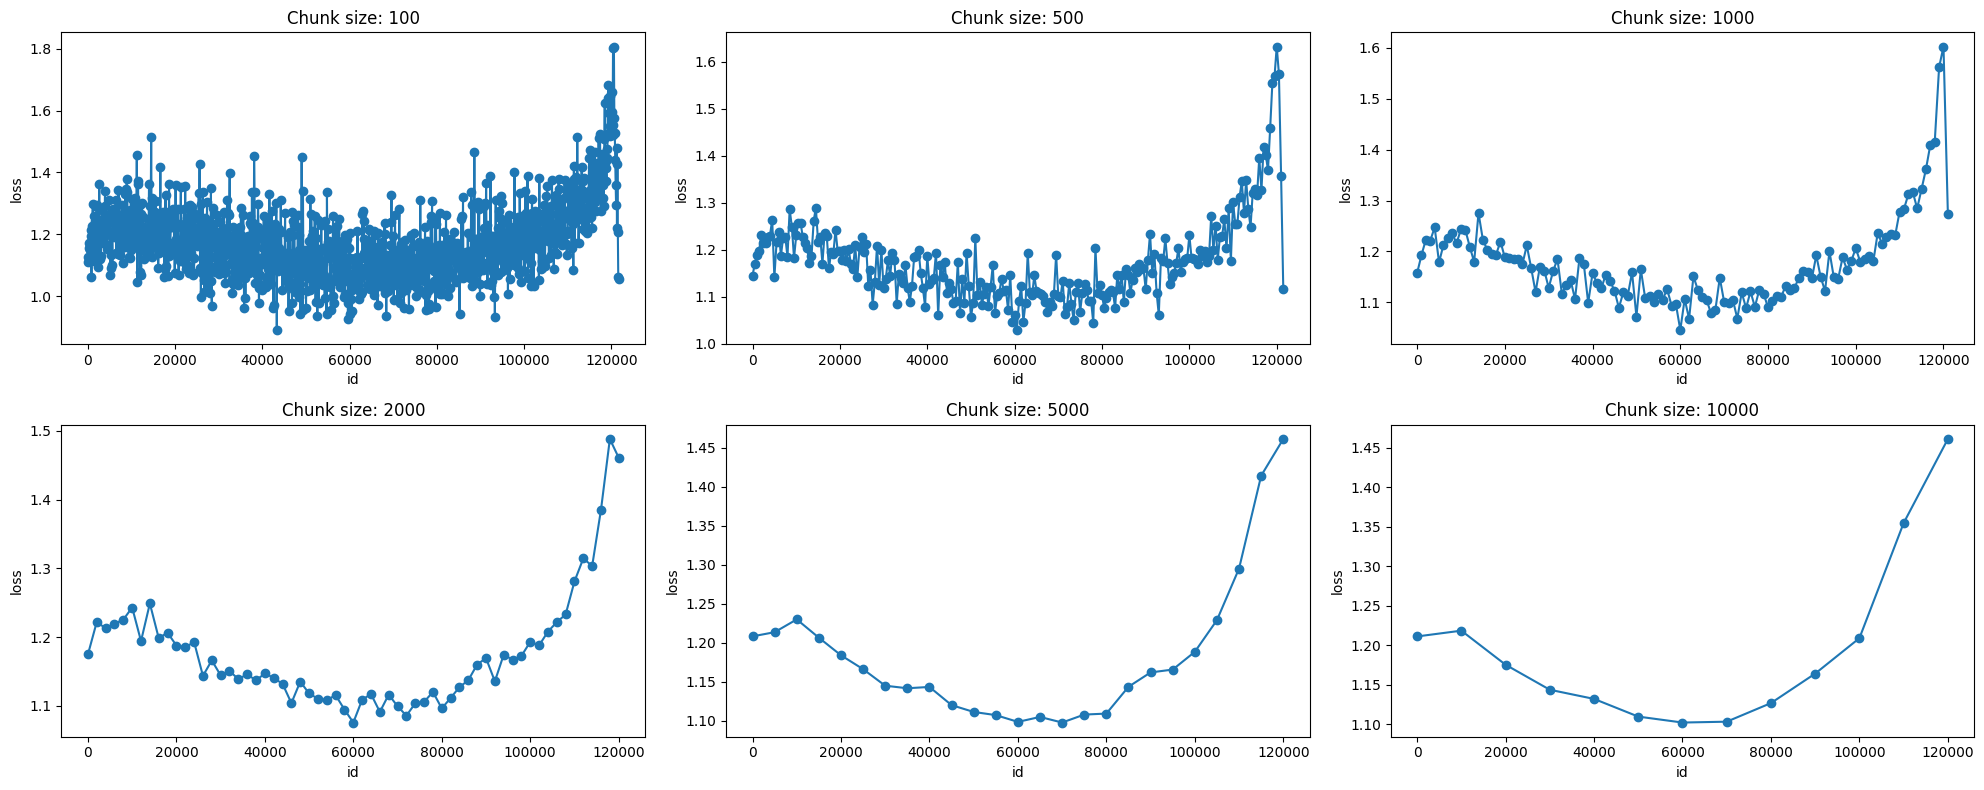

In [3]:
# 定义不同的chunk大小
chunk_sizes = [100, 500, 1000, 2000, 5000, 10000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

# anli_r3

## origin

In [13]:
# /data/home/chenpz/git_clone_project/jupyter_notebook_test/output/anli_r3_loss_FFP_all.jsonl

import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
# /data/home/chenpz/git_clone_project/jupyter_notebook_test/output/anli_r3_loss_FFP_all.jsonl
# /data/home/chenpz/git_clone_project/jupyter_notebook_test/output/anli_r3_loss_trained_By_kcg_addHighPPL_first5000_data_FFP_all.jsonl
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/anli_r3_PPL_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

z = []
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/anli_r3_answerPPL_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        z.append(data['loss'])

# IFD
ifd = np.exp(y)/np.exp(z)

In [22]:
# x = plt.scatter(y/np.array(z), ifd)

from scipy.stats import spearmanr
spearman_corr, _ = spearmanr(y/np.array(z), ifd)
spearman_corr

0.9678487824273314

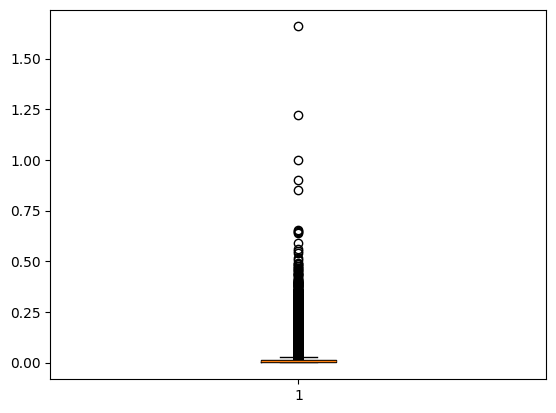

In [24]:
k = plt.boxplot(ifd)

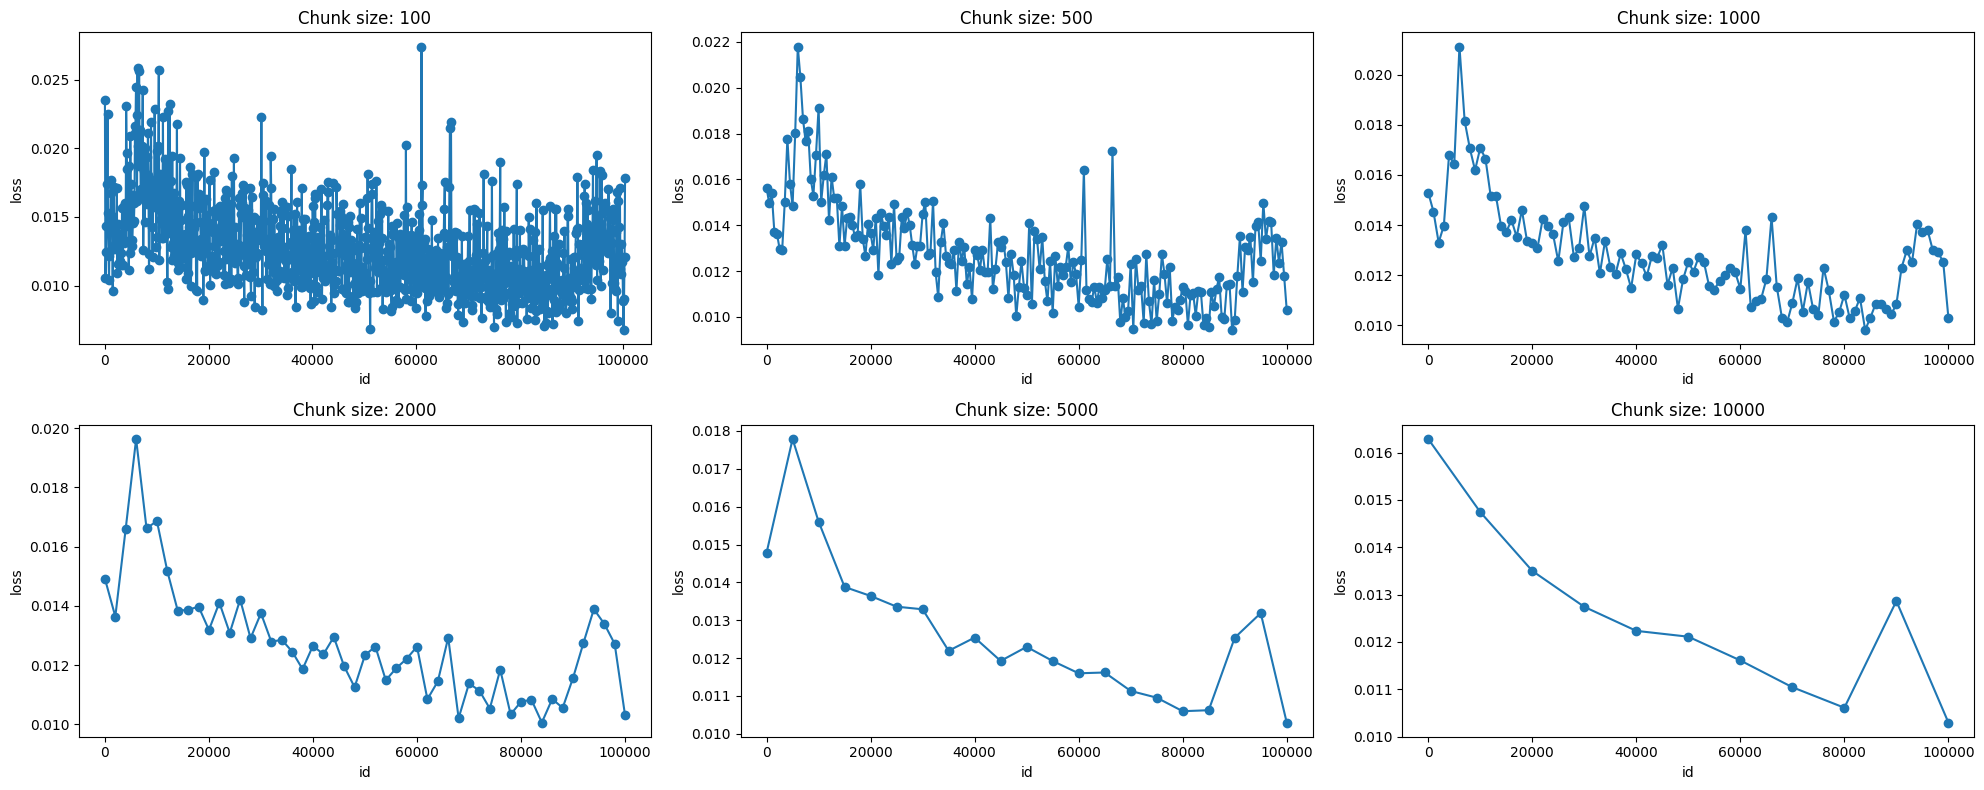

In [10]:
# 定义不同的chunk大小
chunk_sizes = [100, 500, 1000, 2000, 5000, 10000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [2]:
# 
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/kcenters_rank_fromFarPoint.pkl', 'rb') as f:
    res1 = pickle.load(f)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/anli_r3_bge_kcg.pkl', 'rb') as f:
    res2 = pickle.load(f)

In [3]:
index_dict = {value: idx for idx, value in enumerate(res1)}

# 2. 按照 res2 的顺序重新排列 y
y = [y[index_dict[value]] for value in res2[0]]

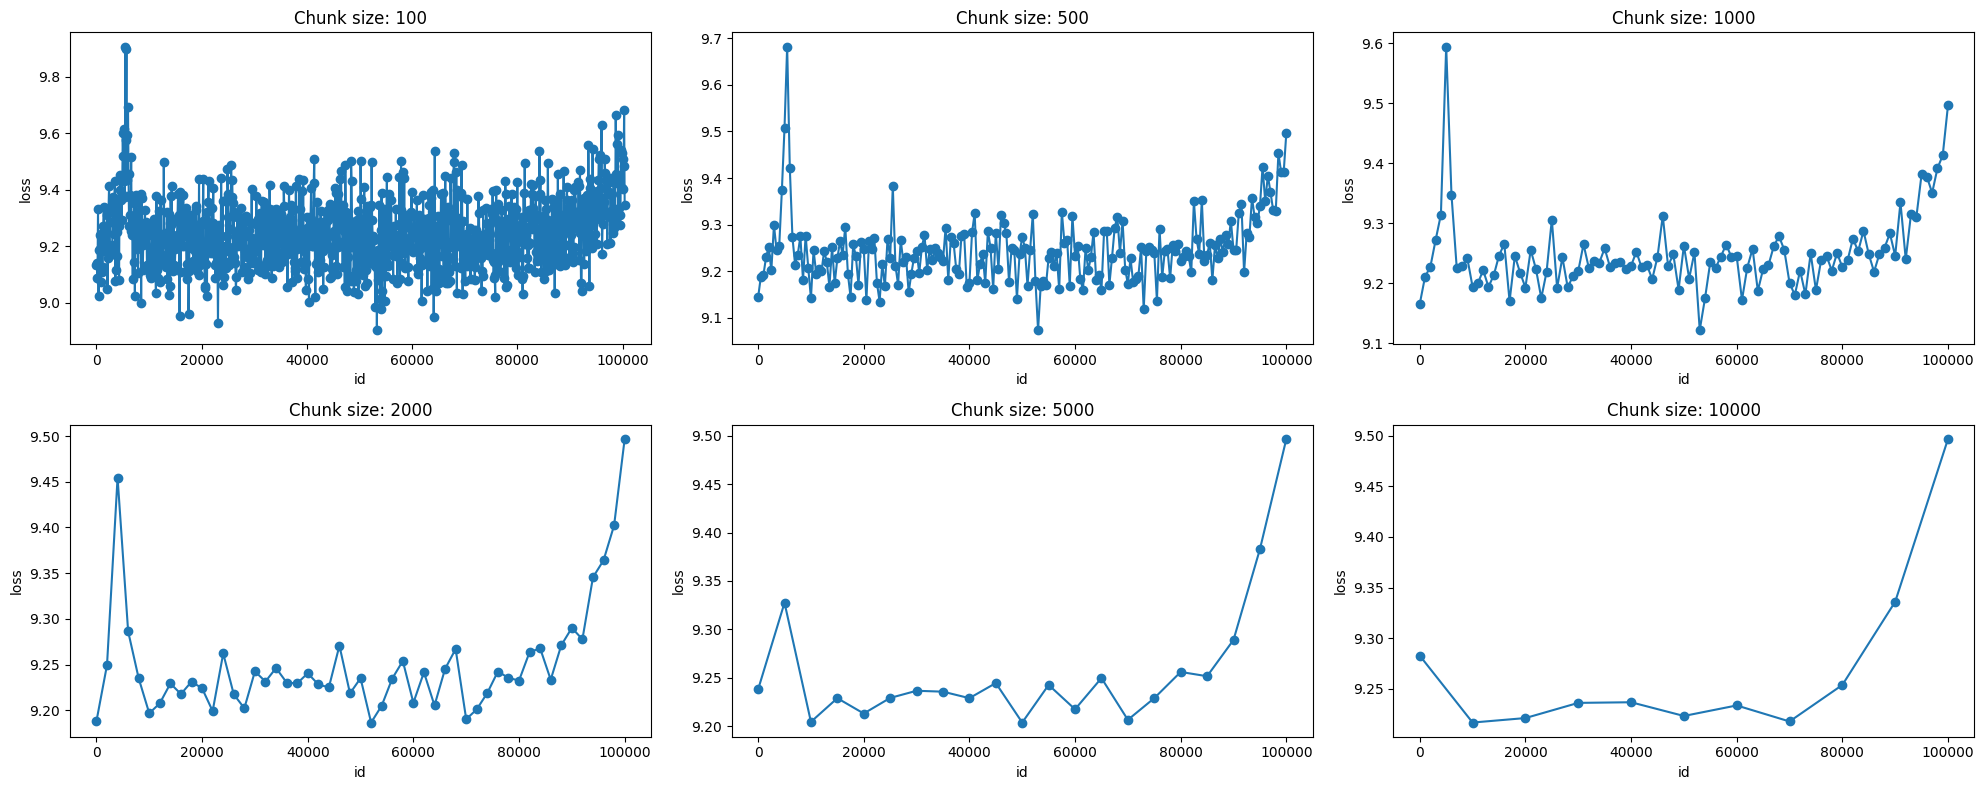

In [4]:
# 定义不同的chunk大小
chunk_sizes = [100, 500, 1000, 2000, 5000, 10000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [14]:
res1_loss = y
res2_loss = [y[index_dict[value]] for value in res2[0]]
set1 = list(set(res1[:5000]).intersection(set(res2[0][:5000])))
set2 = list(set(res1[-5000:]).intersection(set(res2[0][-5000:])))
print(len(set1), len(set2))
set1_loss = np.array([y[index_dict[value]] for value in set1])
set2_loss = np.array([y[index_dict[value]] for value in set2])
np.mean(res1_loss[-5000:]), np.mean(res2_loss[-5000:]) ,np.mean(res1_loss[:5000]), np.mean(res2_loss[:5000])

1169 4549


(9.477743478679656, 9.473157611274718, 9.30263585062027, 9.304724818515778)

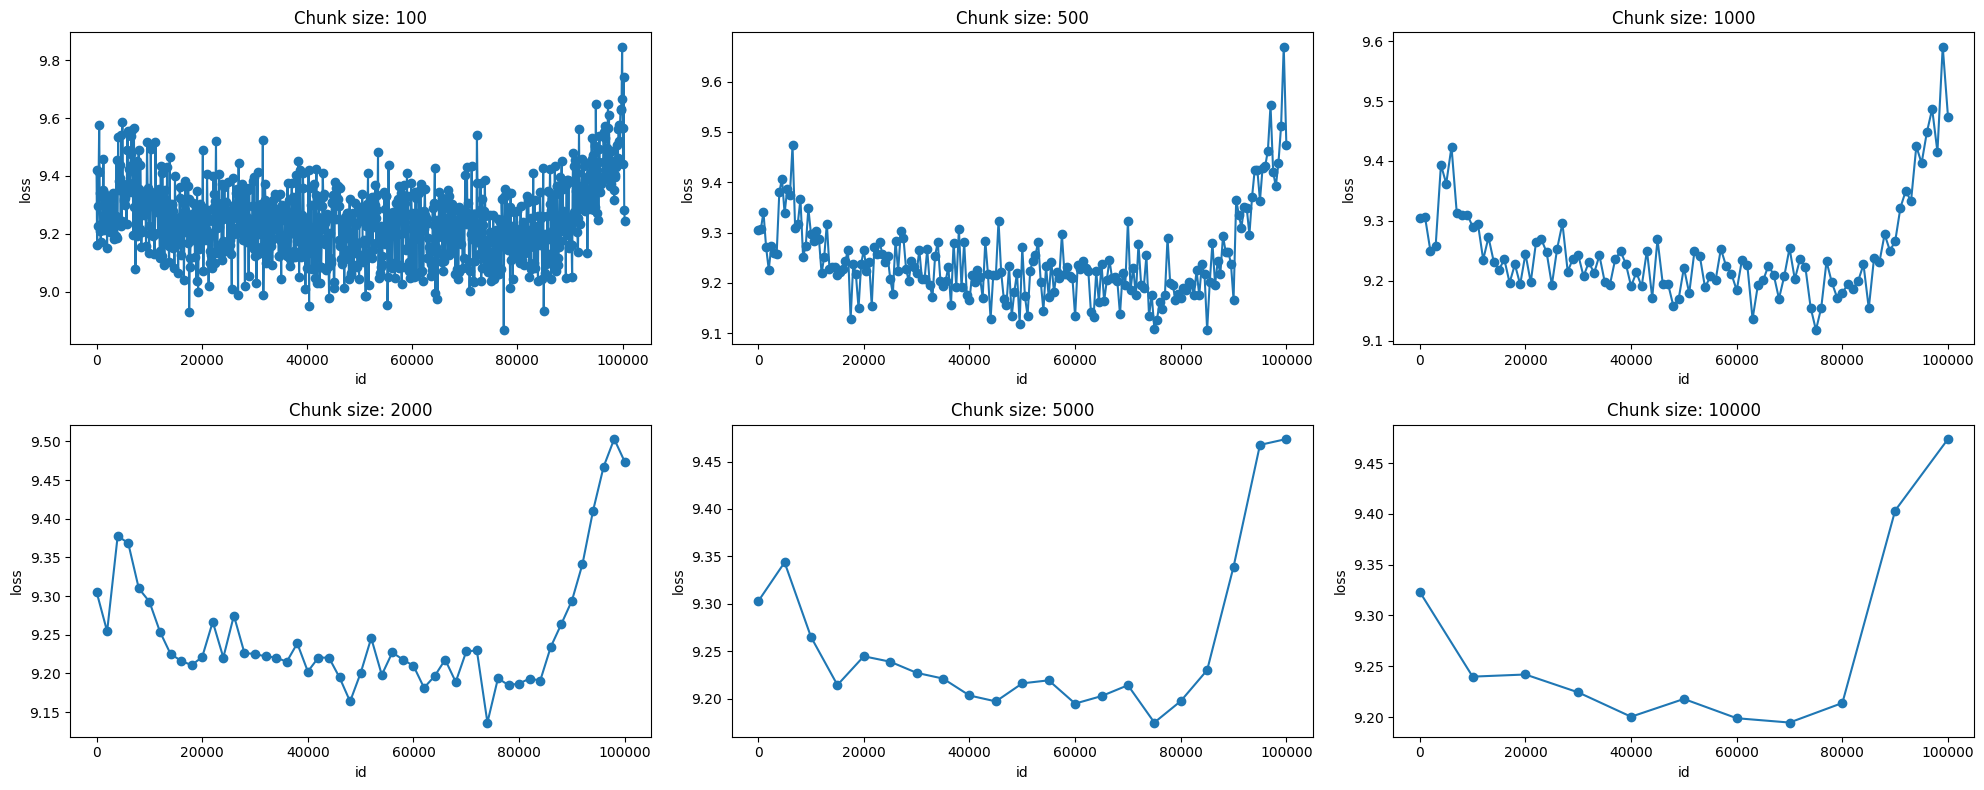

In [9]:
# 定义不同的chunk大小
chunk_sizes = [100, 500, 1000, 2000, 5000, 10000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [5]:
# 均分数据的大小
print(f"dataset: anli_r3, 数据量为：{len(y)}")
chunk_sizes = [1, 10, 50, 100, 500, 1000, 2000, 5000, 10000]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.5
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: anli_r3, 数据量为：100459
chunk_sizes大小为: 1, 选取后50.0%的数据, spearman_corr: 0.055394220249489826
chunk_sizes大小为: 10, 选取后50.0%的数据, spearman_corr: 0.16623115092334403
chunk_sizes大小为: 50, 选取后50.0%的数据, spearman_corr: 0.31682792582673674
chunk_sizes大小为: 100, 选取后50.0%的数据, spearman_corr: 0.38423830004228093
chunk_sizes大小为: 500, 选取后50.0%的数据, spearman_corr: 0.4458474082702387
chunk_sizes大小为: 1000, 选取后50.0%的数据, spearman_corr: 0.5033484162895927
chunk_sizes大小为: 2000, 选取后50.0%的数据, spearman_corr: 0.4871794871794871
chunk_sizes大小为: 5000, 选取后50.0%的数据, spearman_corr: 0.5818181818181819
chunk_sizes大小为: 10000, 选取后50.0%的数据, spearman_corr: 0.6


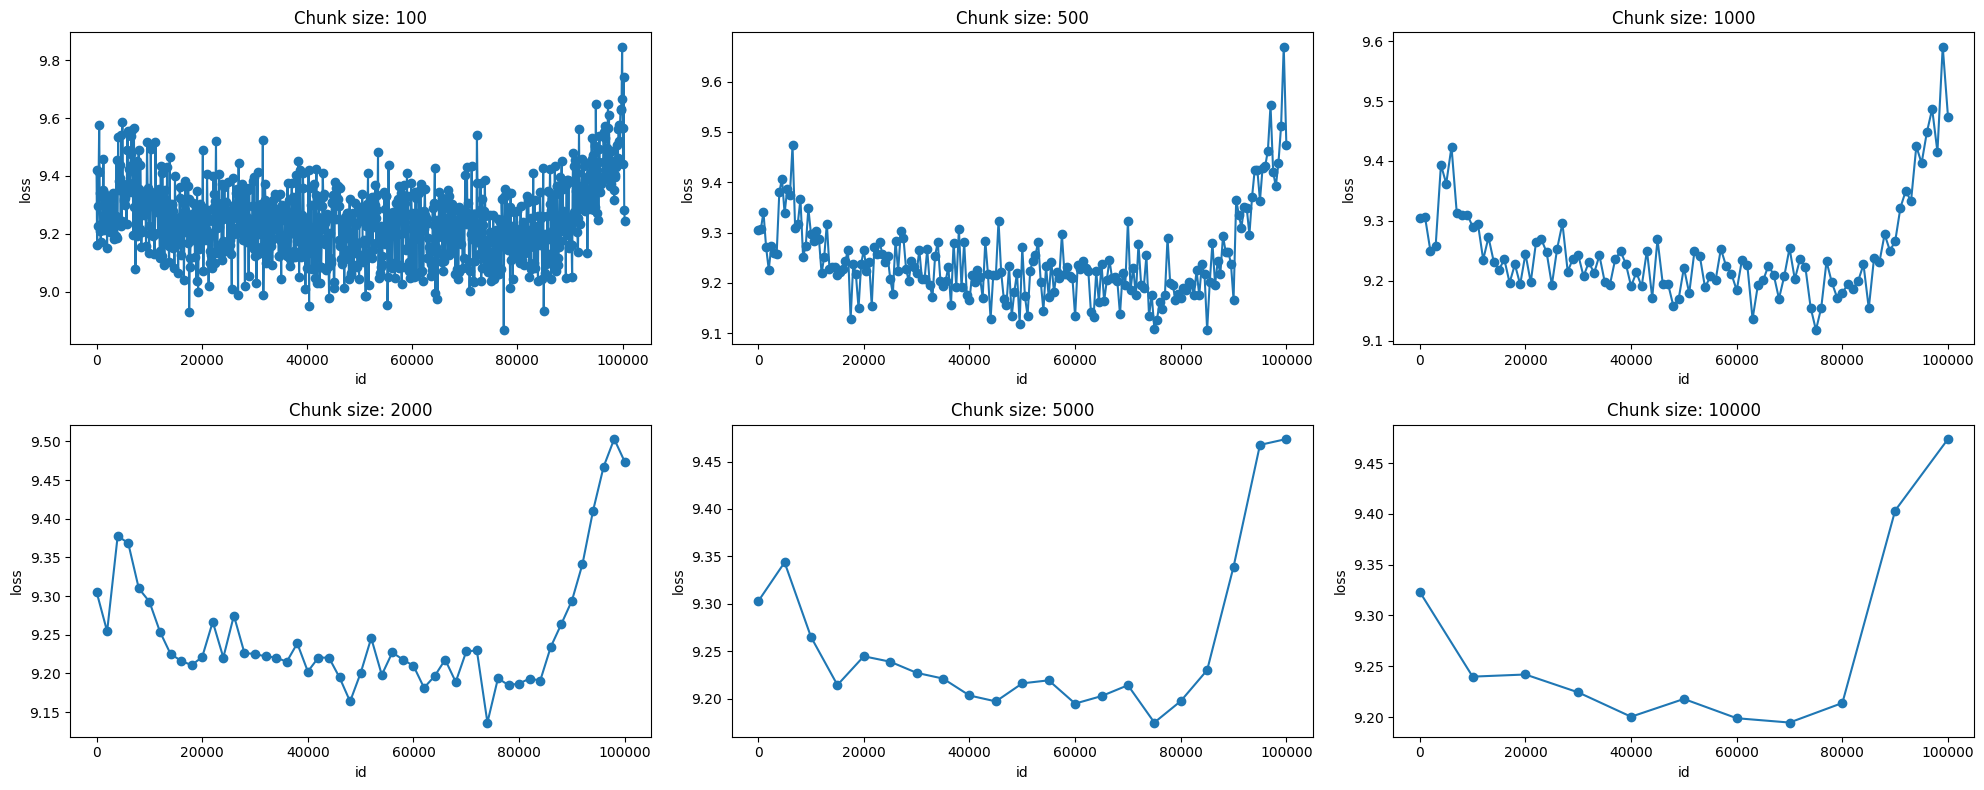

In [7]:
# 定义不同的chunk大小
chunk_sizes = [100, 500, 1000, 2000, 5000, 10000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

# dolly

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/dolly_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

# x = x[:-700]
# y = y[:-700]

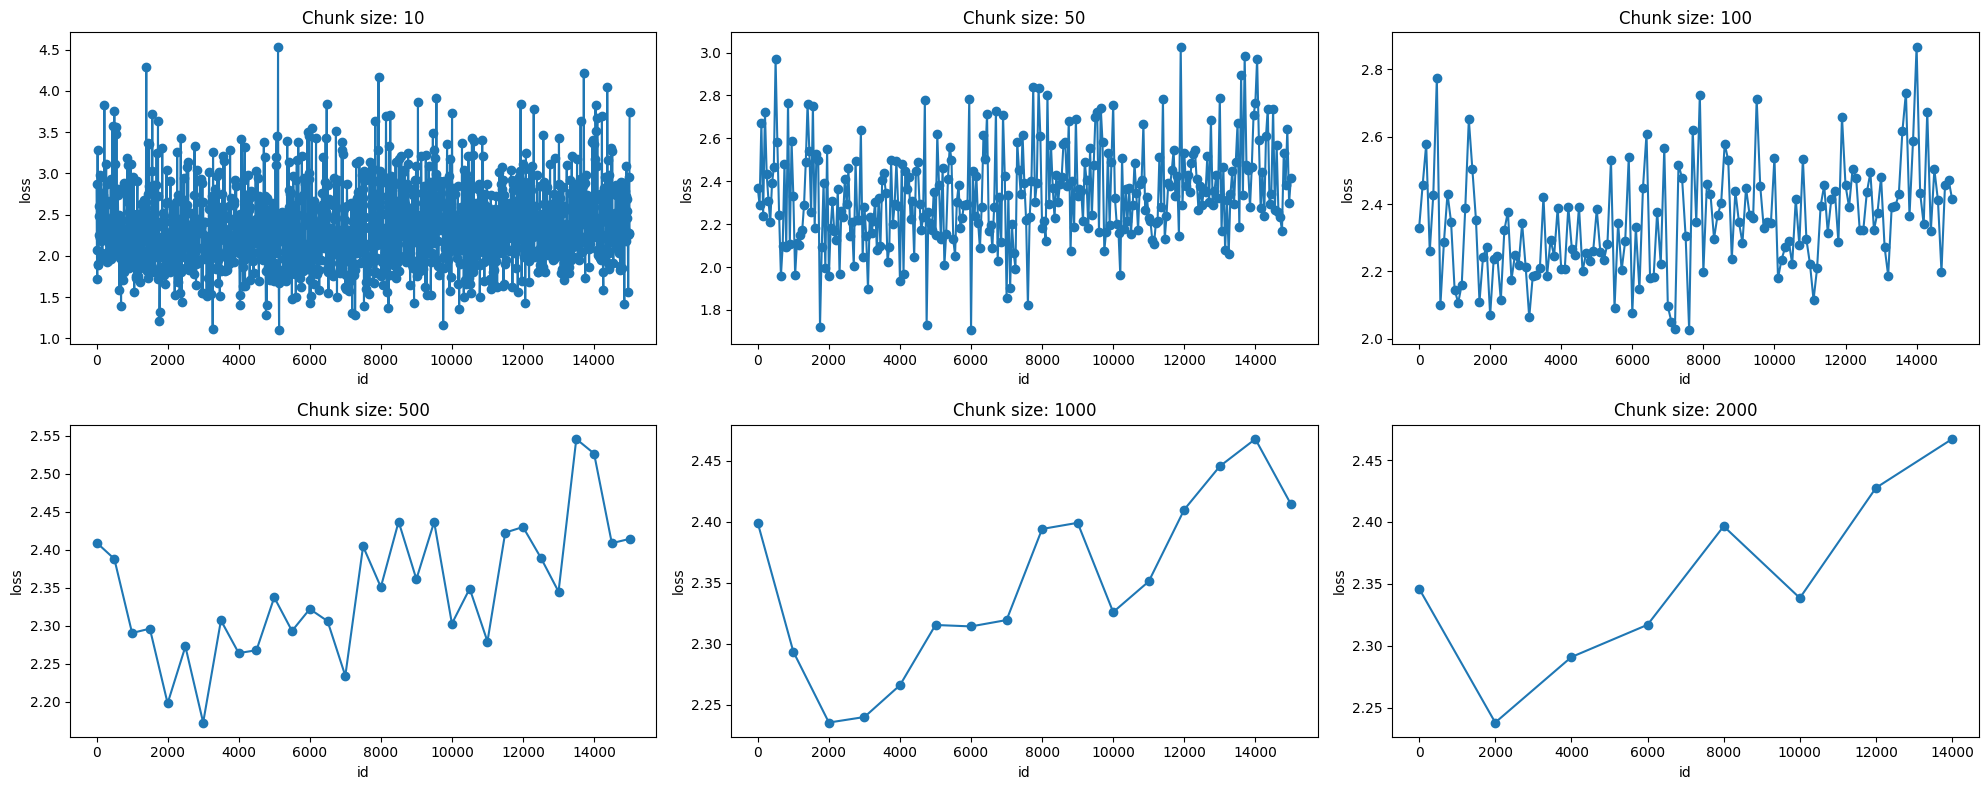

In [14]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/dolly_qa_ffp_rank.pkl', 'rb') as f:
    res1 = pickle.load(f)
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/dolly_fps_rank.pkl', 'rb') as f:
    res2 = pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
y = [y[index_dict[value]] for value in res2[0]]

chunk_sizes = [10,50,100,500,1000,2000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

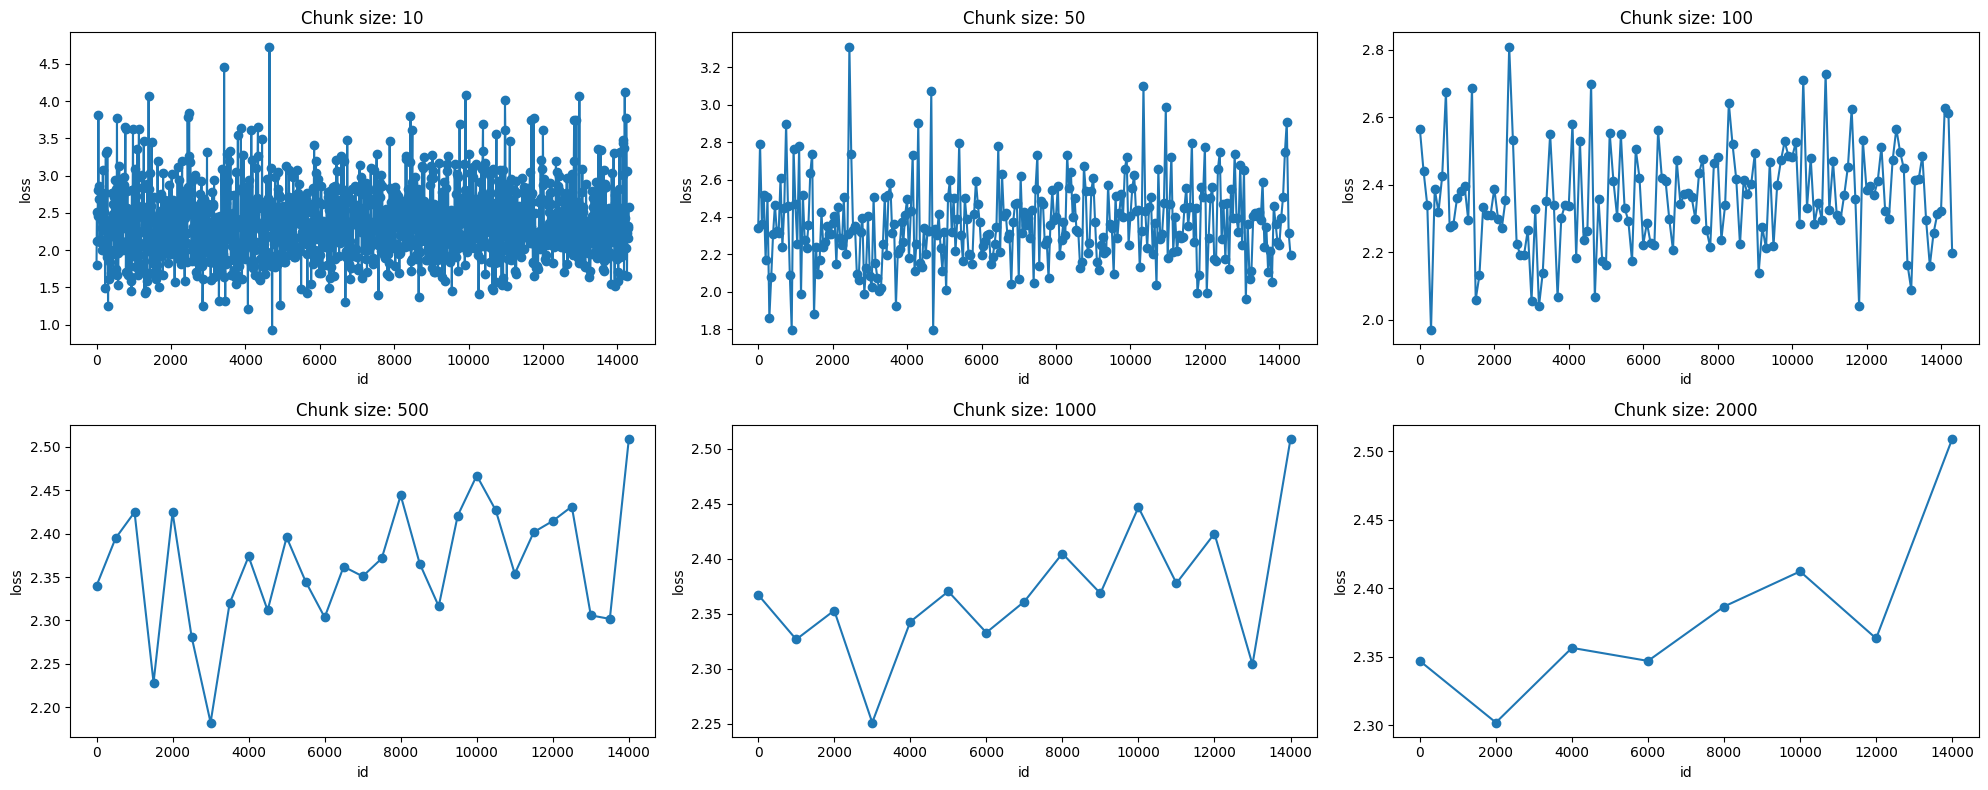

In [40]:
chunk_sizes = [10,50,100,500,1000,2000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

# super_glue_wic
'/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/super_glue_wic_loss_FFP_all.jsonl'

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/super_glue_wic_loss_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

In [17]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/super_glue_wic_ffp_rank.pkl', 'rb') as f:
    res1 = pickle.load(f)
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/super_glue_wic_fps_rank.pkl', 'rb') as f:
    res2 = pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
y = [y[index_dict[value]] for value in res2[0]]

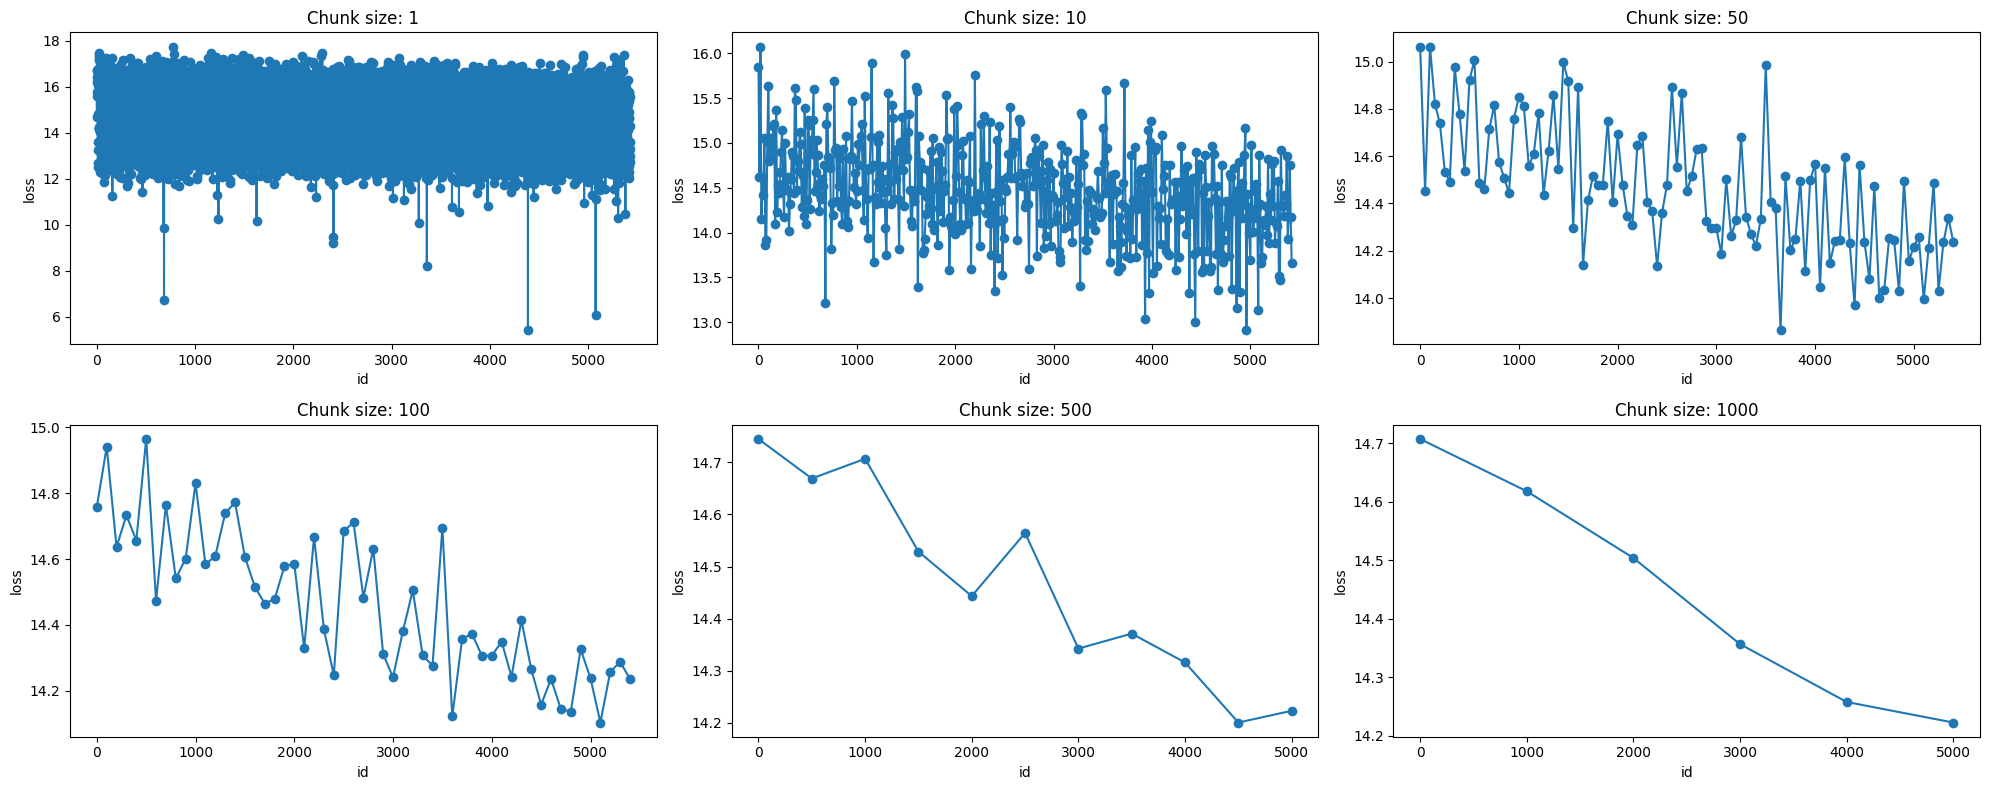

In [18]:
# 定义不同的chunk大小
chunk_sizes = [1, 10, 50, 100, 500, 1000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [14]:
# 均分数据的大小
print(f"dataset: super_glue_wic, 数据量为：{len(y)}")
chunk_sizes = [1, 10, 50, 100, 500, 1000]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.5
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: super_glue_wic, 数据量为：5428
chunk_sizes大小为: 1, 选取后50.0%的数据, spearman_corr: 0.13229831647024629
chunk_sizes大小为: 10, 选取后50.0%的数据, spearman_corr: 0.3648676047200032
chunk_sizes大小为: 50, 选取后50.0%的数据, spearman_corr: 0.6284271284271284
chunk_sizes大小为: 100, 选取后50.0%的数据, spearman_corr: 0.7476737821565407
chunk_sizes大小为: 500, 选取后50.0%的数据, spearman_corr: 0.8857142857142858
chunk_sizes大小为: 1000, 选取后50.0%的数据, spearman_corr: 1.0


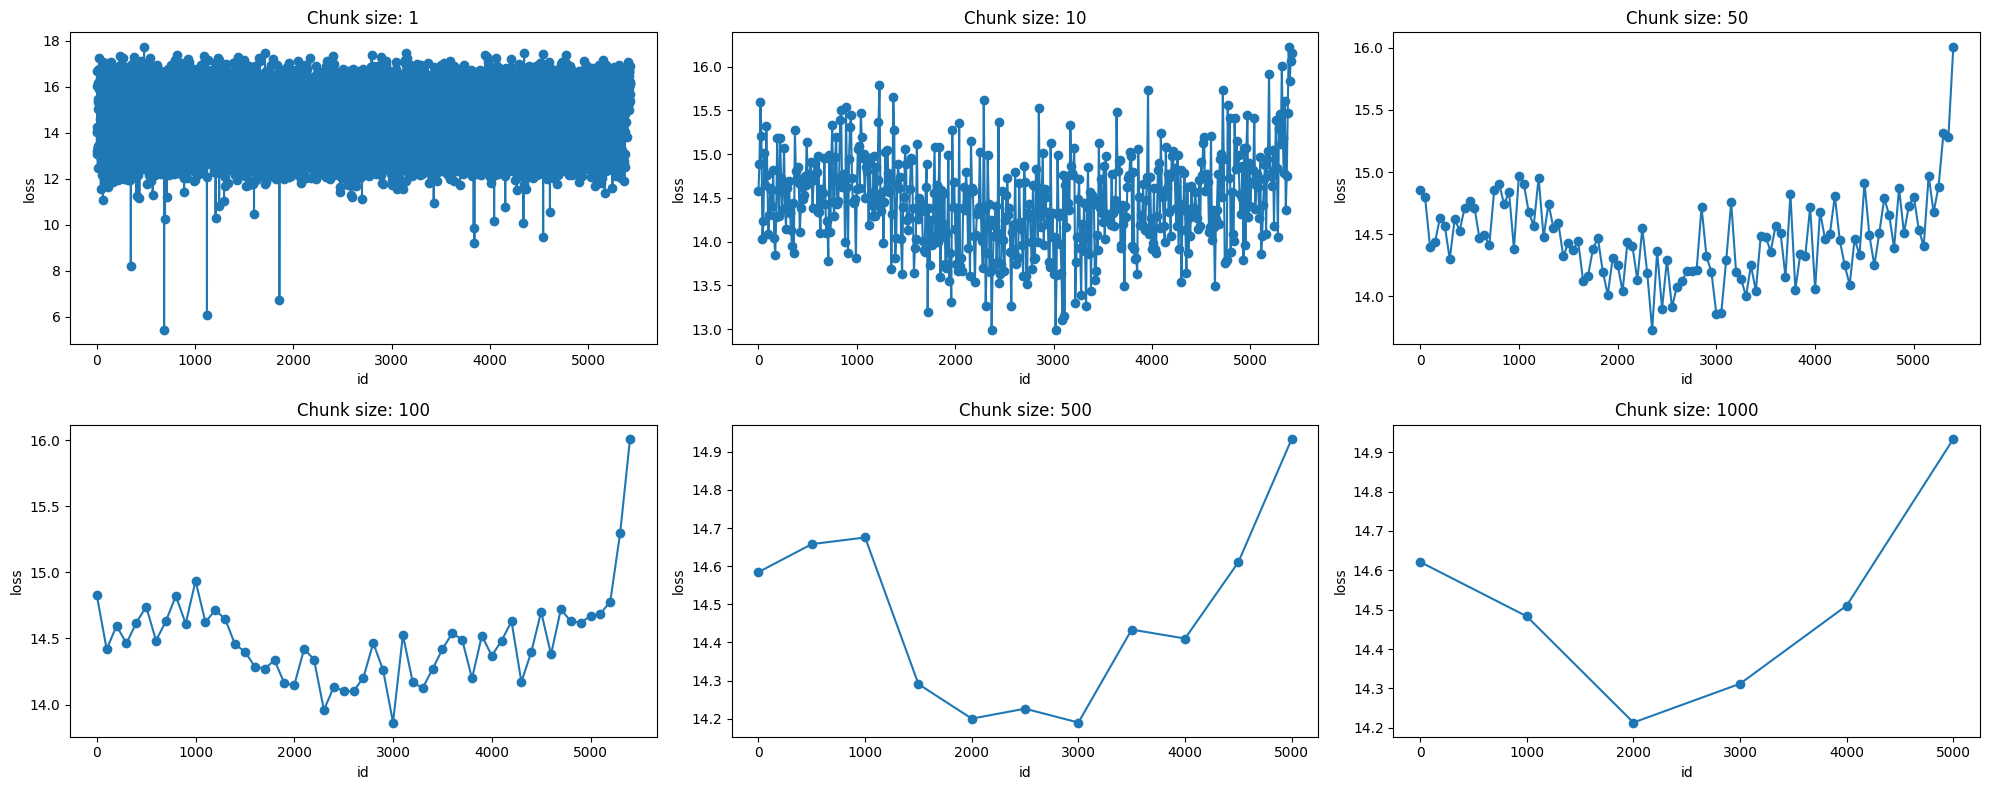

In [2]:
# 定义不同的chunk大小
chunk_sizes = [1, 10, 50, 100, 500, 1000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

# sst2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/sst2_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

In [5]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/sst2_ffp_rank.pkl', 'rb') as f:
    res1 = pickle.load(f)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/sst2_fps_rank.pkl', 'rb') as f:
    res2 = pickle.load(f)



In [6]:
index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
y = [y[index_dict[value]] for value in res2[0]]
# import random
# random.shuffle(sorted_y)

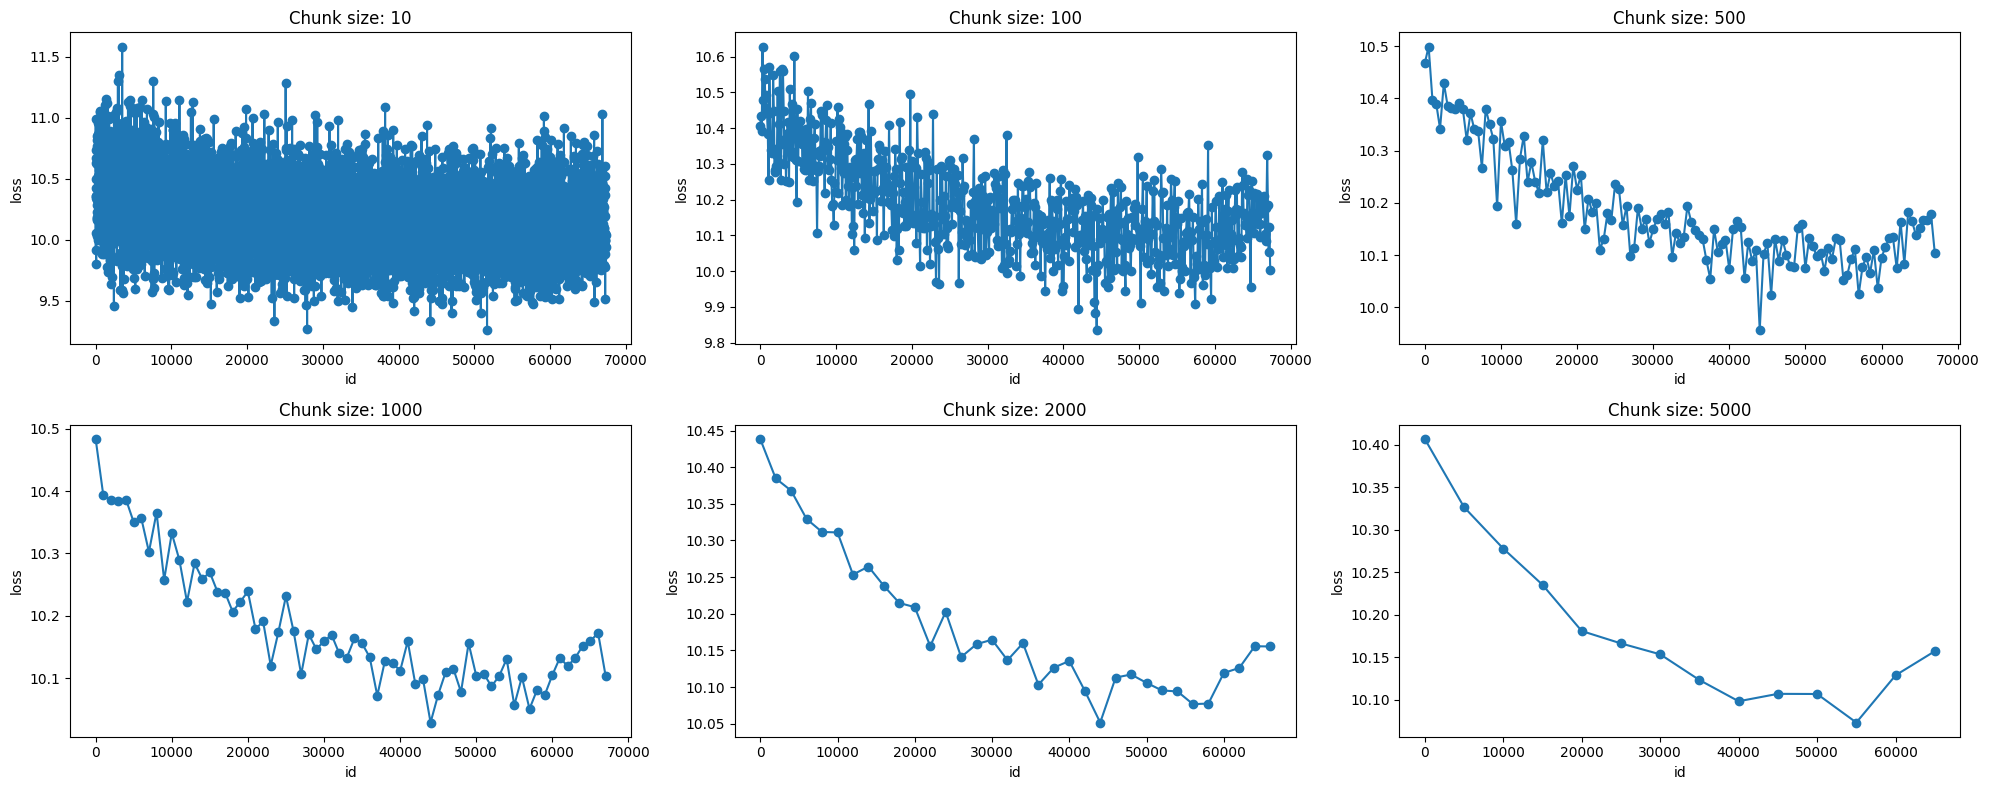

In [7]:
# 定义不同的chunk大小
chunk_sizes = [10, 100, 500, 1000, 2000, 5000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [13]:
# 均分数据的大小
print(f"dataset: sst2, 数据量为：{len(y)}")
chunk_sizes = [1, 10, 50, 100, 500, 1000, 2000, 5000, 10000]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.5
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: sst2, 数据量为：67349
chunk_sizes大小为: 1, 选取后50.0%的数据, spearman_corr: 0.08006324969874587
chunk_sizes大小为: 10, 选取后50.0%的数据, spearman_corr: 0.24351848379899435
chunk_sizes大小为: 50, 选取后50.0%的数据, spearman_corr: 0.4883087425148528
chunk_sizes大小为: 100, 选取后50.0%的数据, spearman_corr: 0.6322177309109515
chunk_sizes大小为: 500, 选取后50.0%的数据, spearman_corr: 0.8052448753674085
chunk_sizes大小为: 1000, 选取后50.0%的数据, spearman_corr: 0.7821237585943468
chunk_sizes大小为: 2000, 选取后50.0%的数据, spearman_corr: 0.8455882352941178
chunk_sizes大小为: 5000, 选取后50.0%的数据, spearman_corr: 0.9642857142857145
chunk_sizes大小为: 10000, 选取后50.0%的数据, spearman_corr: 1.0


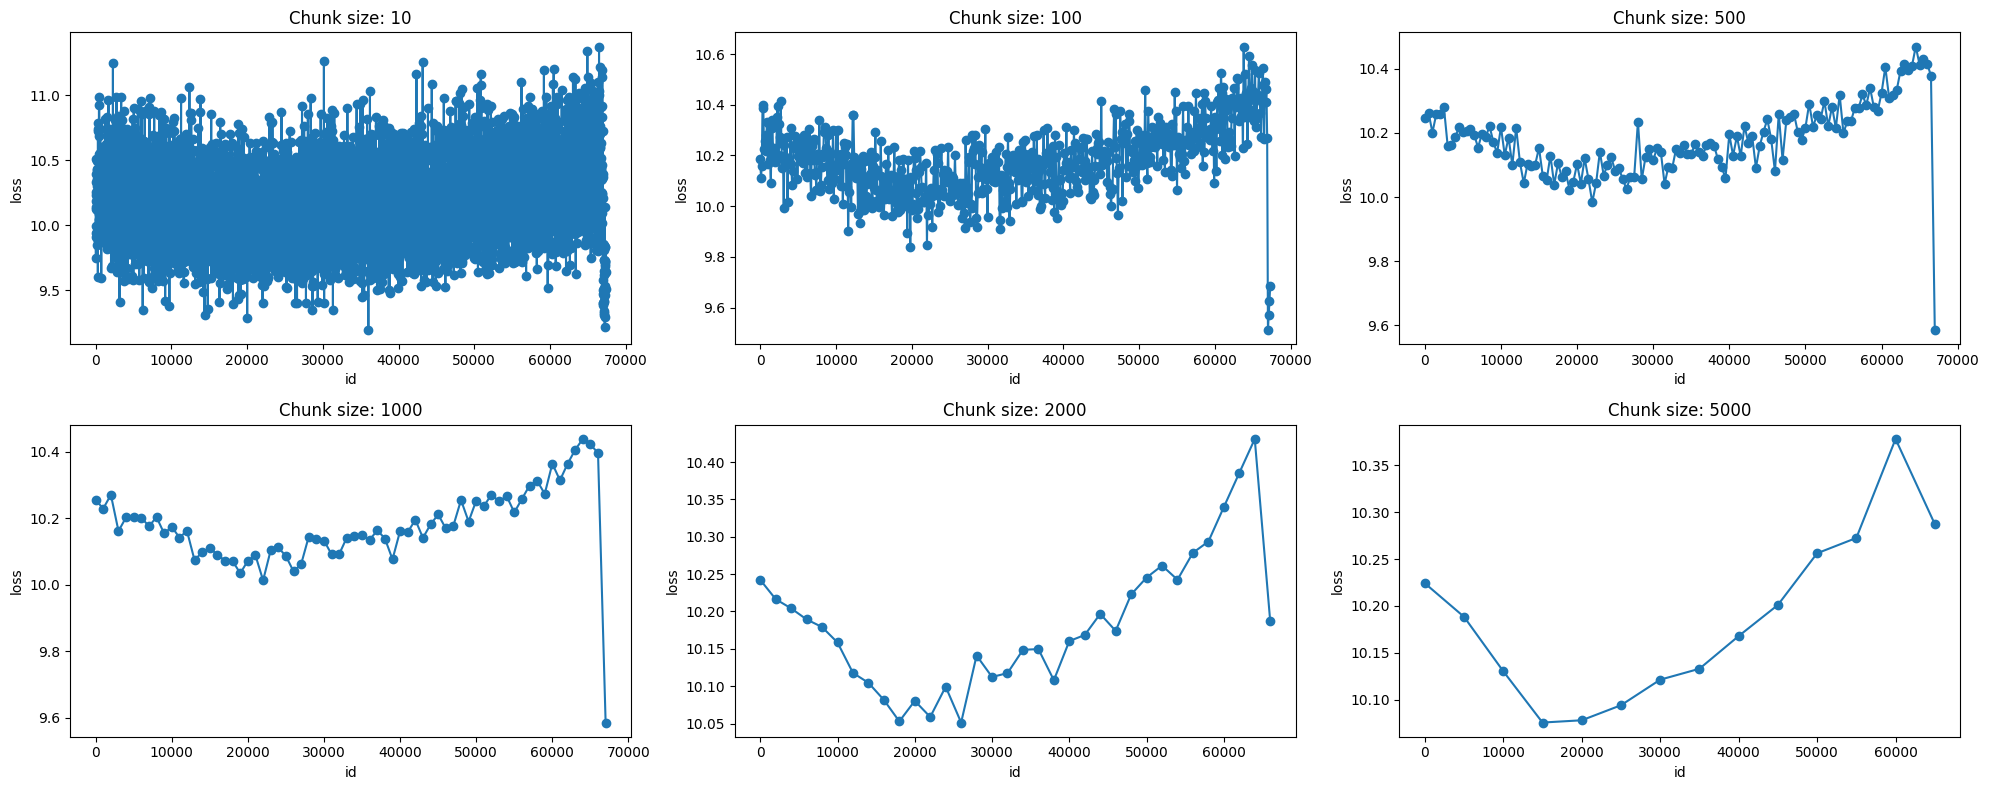

In [52]:
# 定义不同的chunk大小
chunk_sizes = [10, 100, 500, 1000, 2000, 5000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(sorted_y), n))
    new_idx.append(len(sorted_y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = sorted_y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

# finance_alpaca

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/finance_alpaca_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

In [2]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/finance_alpaca_o_qa_ffp_rank.pkl', 'rb') as f:
    res1 = pickle.load(f)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/finance_alpaca_fps_rank.pkl', 'rb') as f:
    res2 = pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
y = [y[index_dict[value]] for value in res2[0]]

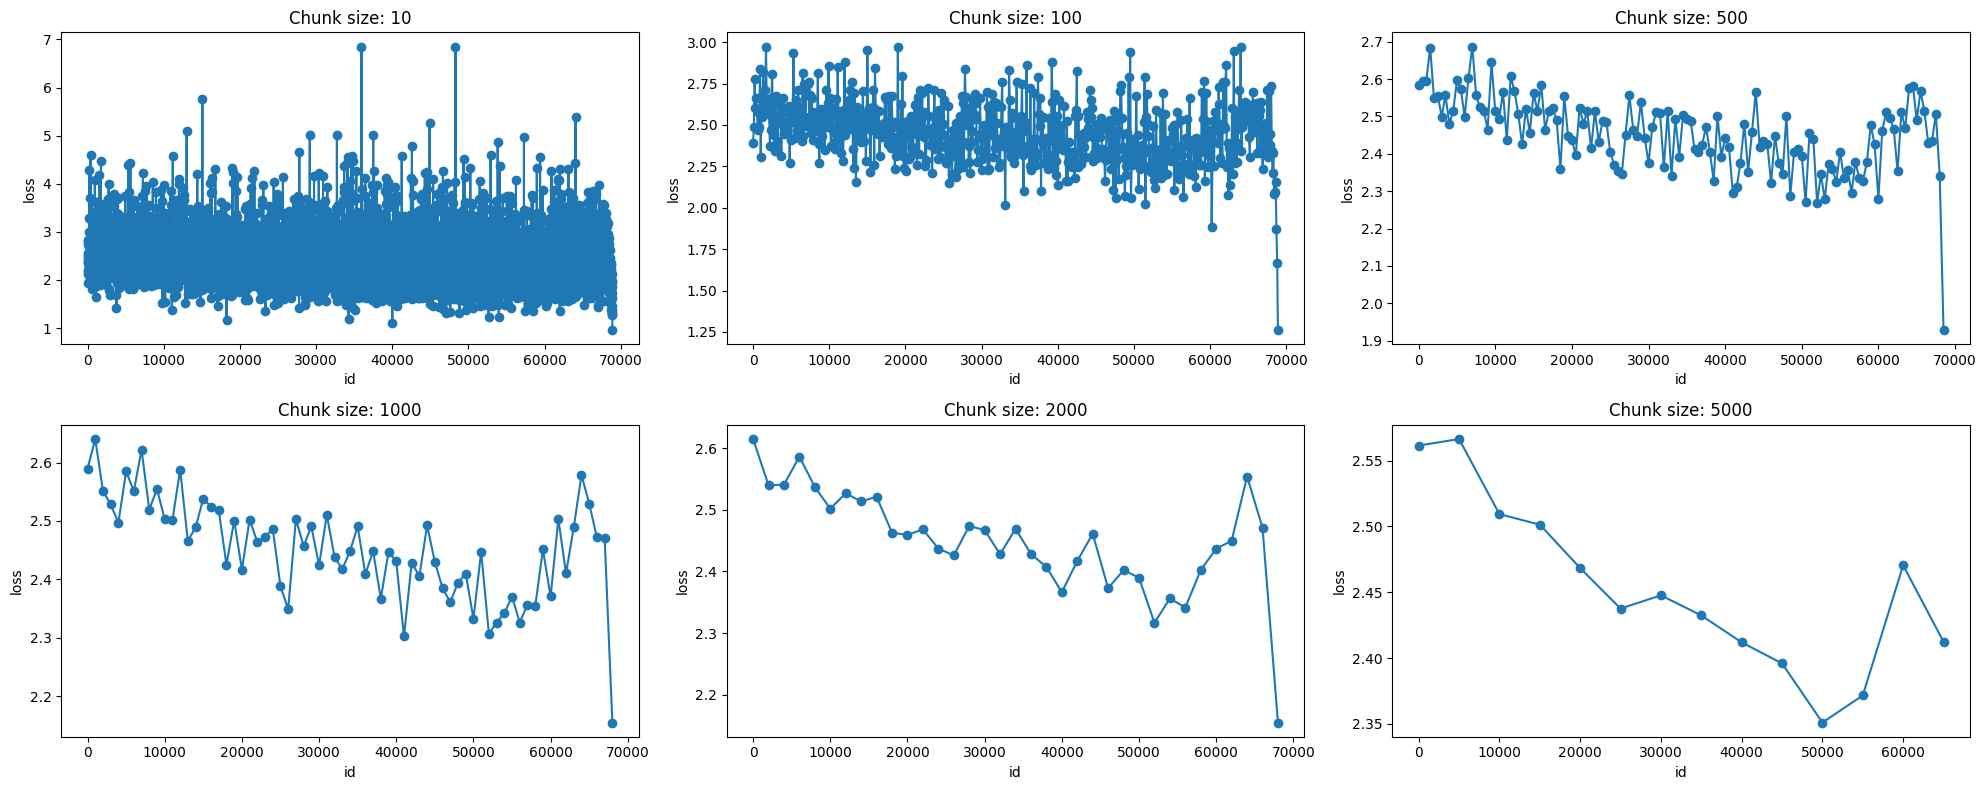

In [4]:
# 定义不同的chunk大小
chunk_sizes = [10, 100, 500, 1000, 2000, 5000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [9]:
# 均分数据的大小
print(f"dataset: finance_alpaca, 数据量为：{len(y)}")
chunk_sizes = [1, 10,50, 100, 500, 1000, 2000, 5000]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.5
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: finance_alpaca, 数据量为：68912
chunk_sizes大小为: 1, 选取后50.0%的数据, spearman_corr: 0.35235070035977895
chunk_sizes大小为: 10, 选取后50.0%的数据, spearman_corr: 0.4619443322507098
chunk_sizes大小为: 50, 选取后50.0%的数据, spearman_corr: 0.5806314671309228
chunk_sizes大小为: 100, 选取后50.0%的数据, spearman_corr: 0.5877364886584804
chunk_sizes大小为: 500, 选取后50.0%的数据, spearman_corr: 0.5165875045670443
chunk_sizes大小为: 1000, 选取后50.0%的数据, spearman_corr: 0.5053221288515407
chunk_sizes大小为: 2000, 选取后50.0%的数据, spearman_corr: 0.479876160990712
chunk_sizes大小为: 5000, 选取后50.0%的数据, spearman_corr: 0.642857142857143


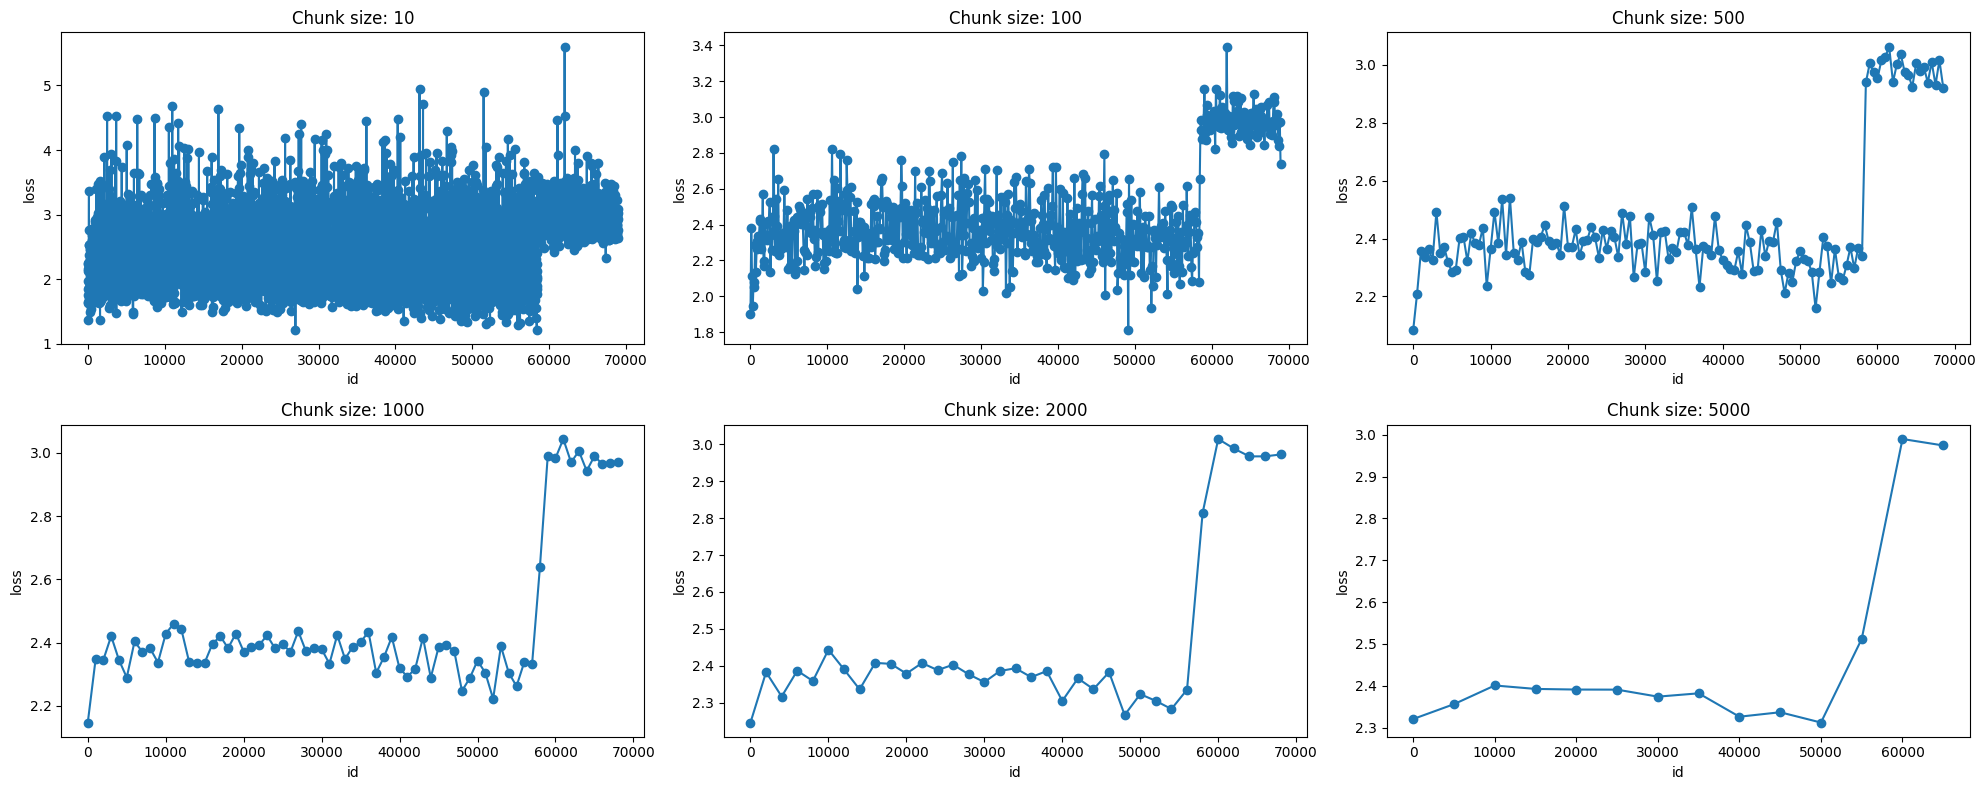

In [6]:
# 定义不同的chunk大小
chunk_sizes = [10, 100, 500, 1000, 2000, 5000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

# squad_v2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/squad_v2_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

In [2]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/squad_v2_o_qa_ffp_rank.pkl', 'rb') as f:
    res1 = pickle.load(f)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/squad_v2_fps_rank.pkl', 'rb') as f:
    res2 = pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
y = [y[index_dict[value]] for value in res2[0]]

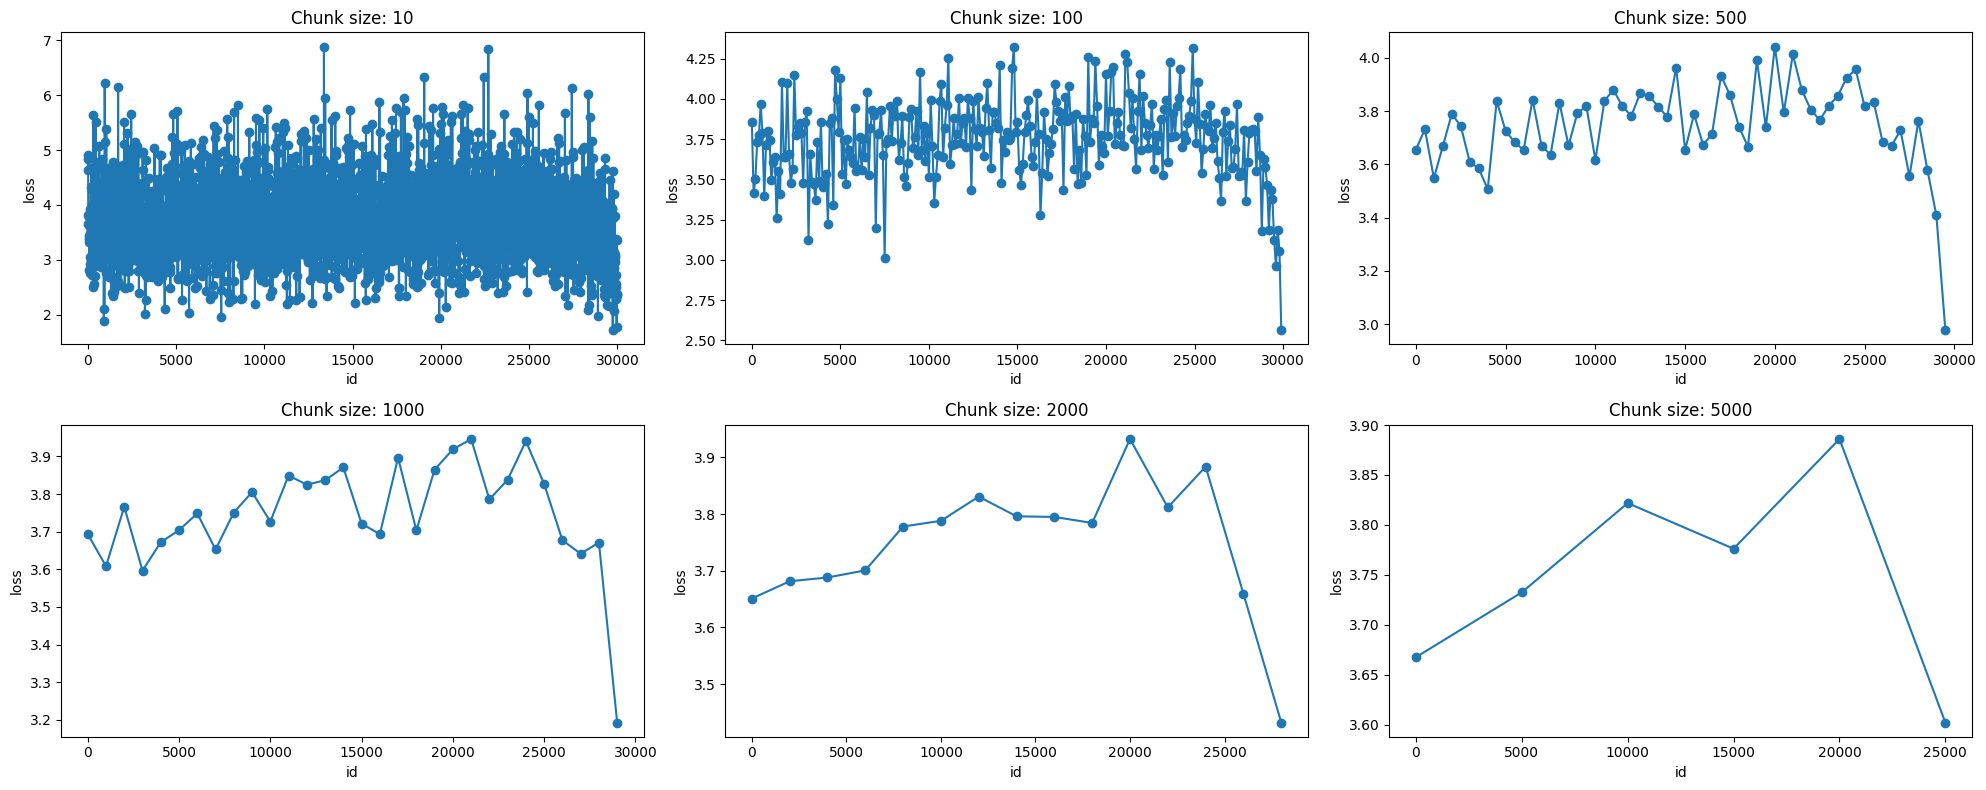

In [3]:
# 定义不同的chunk大小
chunk_sizes = [10, 100, 500, 1000, 2000, 5000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()

In [15]:
# 均分数据的大小
print(f"dataset: squad_v2, 数据量为：{len(y)}")
chunk_sizes = [1, 10,50, 100, 500, 1000, 2000, 5000]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.5
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: squad_v2, 数据量为：30000
chunk_sizes大小为: 1, 选取后50.0%的数据, spearman_corr: 0.05498563057543826
chunk_sizes大小为: 10, 选取后50.0%的数据, spearman_corr: 0.15637930861302607
chunk_sizes大小为: 50, 选取后50.0%的数据, spearman_corr: 0.36419249102767803
chunk_sizes大小为: 100, 选取后50.0%的数据, spearman_corr: 0.46887239432863687
chunk_sizes大小为: 500, 选取后50.0%的数据, spearman_corr: 0.7864293659621803
chunk_sizes大小为: 1000, 选取后50.0%的数据, spearman_corr: 0.8785714285714284
chunk_sizes大小为: 2000, 选取后50.0%的数据, spearman_corr: 0.9523809523809524
chunk_sizes大小为: 5000, 选取后50.0%的数据, spearman_corr: 1.0


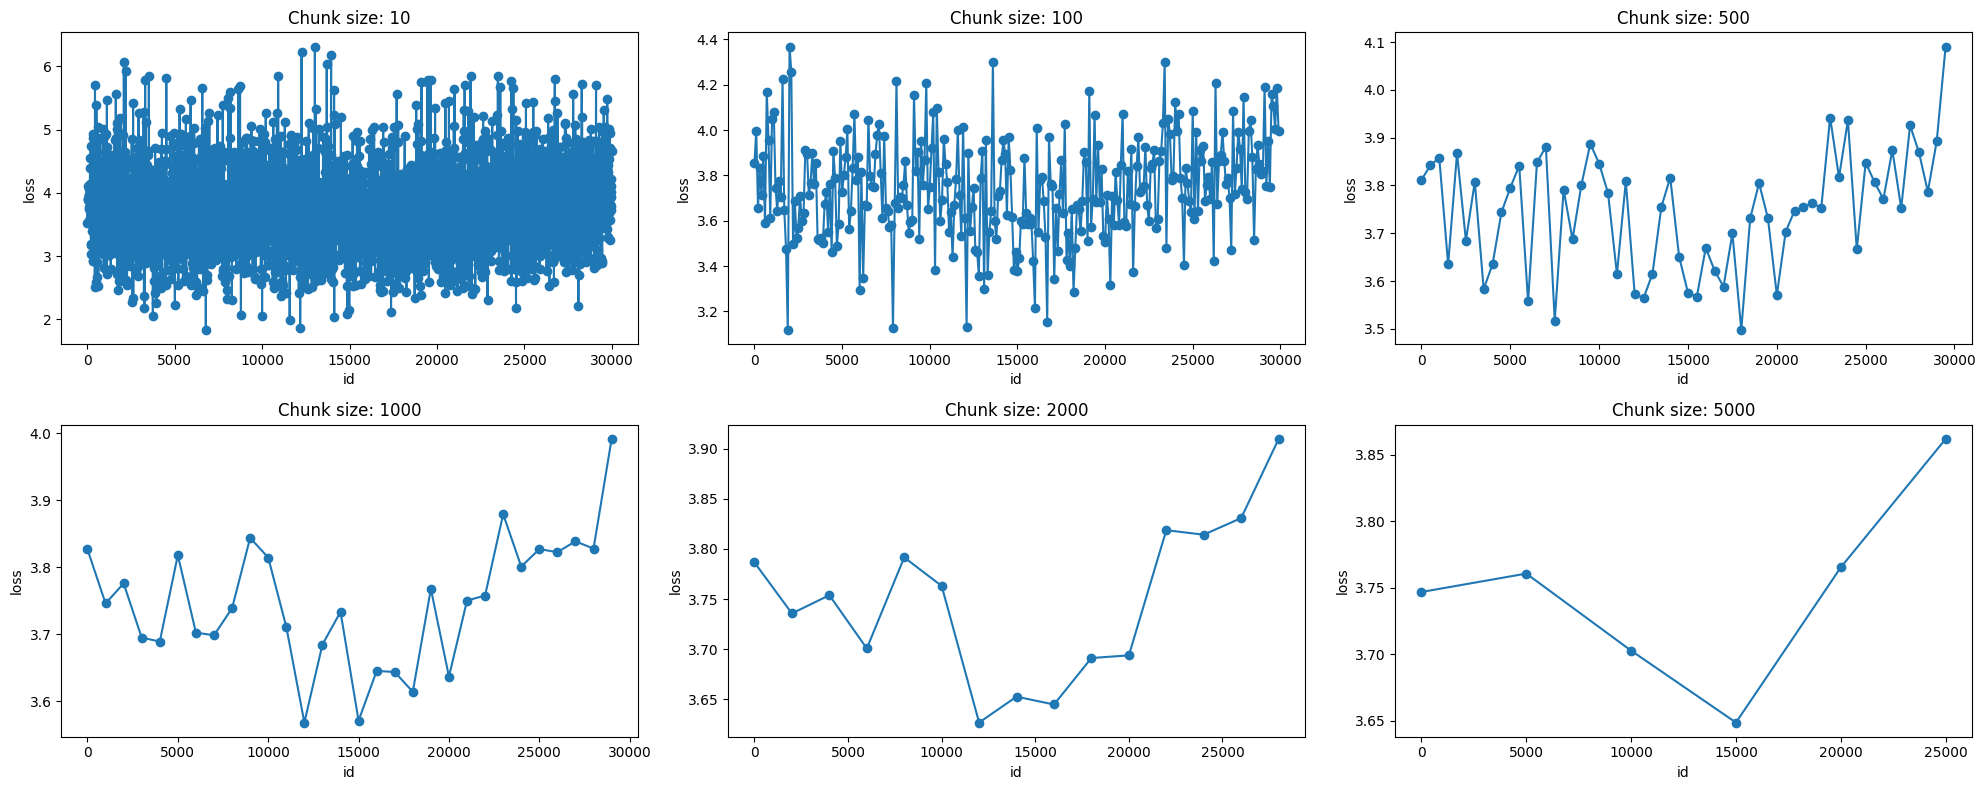

In [2]:
# 定义不同的chunk大小
chunk_sizes = [10, 100, 500, 1000, 2000, 5000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')

# 调整布局
plt.tight_layout()
plt.show()